In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
from uncertainties import ufloat, nominal_value, std_dev, ufloat_fromstr
import numpy as np
import scipy.stats
import seaborn as sns
from cobra.io import read_sbml_model
from equilibrator_api import ComponentContribution, Reaction, Q_, R, default_T
from equilibrator_cache.compatibility import map_cobra_metabolites

In [2]:
def eval_Km(value):
    """
        This function is needed since some Km values
        are a list and we need to calculate the geometric mean,
        while others are a single value.
    """
    if pd.isnull(value):
        return np.nan
    Km = eval(value)
    if type(Km) == list:
        return scipy.stats.gmean(Km)
    else:
        return float(Km)

# read the table with enzyme kinetic data and substrates info
kinetics_df = pd.read_csv('data/enzyme_kinetics.csv', index_col=0)
kinetics_df["Km_uM"] = kinetics_df.Km_uM.apply(eval_Km)

# read the table containing the protein abundance data (Schmidt et al.)
protein_df = pd.read_csv('data/protein_abundance_mmol_per_gCDW.csv', index_col=0)
protein_df = protein_df.reset_index().melt(id_vars=["reaction_BiGG_ID", "gene"], var_name="condition", value_name="protein_abundance_mmol_per_gCDW")

# read the table containing the metabolite abundance data
metabolite_df = pd.read_csv('data/metabolite_concentration_umol_per_gCDW.csv', index_col=(0,1))
metabolite_df = metabolite_df.applymap(lambda x: ufloat_fromstr(x) if type(x)==str else np.nan)
metabolite_df = metabolite_df.reset_index().melt(id_vars=["metabolite", "KEGG_ID"], var_name="condition", value_name="metabolite_concentration_umol_per_gCDW")

# read the flux data (from two sources, Davidi et al. and Gerosa et al.)
davidi_flux_df = pd.read_csv('data/flux_mmol_per_gCDW_s_davidi.csv', index_col=0)
davidi_flux_df = davidi_flux_df.reset_index().melt(id_vars="reaction_BiGG_ID", var_name="condition", value_name="flux_mmol_per_gCDW_sec")
davidi_flux_df["flux_mmol_per_gCDW_sec"] = davidi_flux_df.flux_mmol_per_gCDW_sec.apply(lambda x: ufloat(x, 0))
davidi_flux_df["flux_source"] = "Davidi"
gerosa_flux_df = pd.read_csv('data/flux_mmol_per_gCDW_h_gerosa.csv', index_col=0)
gerosa_flux_df = gerosa_flux_df.applymap(lambda x: ufloat_fromstr(x) if type(x)==str else np.nan)
gerosa_flux_df = gerosa_flux_df.reset_index().melt(id_vars="reaction_BiGG_ID", var_name="condition", value_name="flux_mmol_per_gCDW_h")
gerosa_flux_df["flux_mmol_per_gCDW_sec"] = gerosa_flux_df.flux_mmol_per_gCDW_h / 3600.0
gerosa_flux_df.drop("flux_mmol_per_gCDW_h", axis=1, inplace=True)
gerosa_flux_df["flux_source"] = "Gerosa"
flux_df = pd.concat([davidi_flux_df, gerosa_flux_df])

## Prepare data for plotting

In [3]:
if os.path.exists("res/joined_data_table.csv"):
    joined_df = pd.read_csv("res/joined_data_table.csv")
    joined_df["dGm"] = joined_df.physiological_dg_prime.str.findall("^\(([\-0-9\.]+)").str[0].apply(float)
    for col in [
        "flux_mmol_per_gCDW_sec",
        "kapp_1_per_sec",
        "metabolite_concentration_umol_per_gCDW",
        "saturation",
        "cofactor_concentration_umol_per_gCDW"
    ]:
        joined_df.loc[:, col] = joined_df.loc[:, col].apply(lambda x: np.nan if pd.isnull(x) else ufloat_fromstr(x))
else:
    # join the kcat upper bound with the flux data
    # calculate the flux upper bound based on abundance and kcat
    # the resulting units are mmol_per_gCDW x 1_per_sec = mmol_per_gCDW_sec

    kcat_ub = protein_df.join(kinetics_df.drop("gene", axis="columns"), on="reaction_BiGG_ID")
    kcat_ub["kcat_x_adunbance_mmol_per_gCDW_sec"] = kcat_ub.kcat_1_per_sec * kcat_ub.protein_abundance_mmol_per_gCDW
    joined_df = pd.merge(kcat_ub, flux_df, on=["reaction_BiGG_ID", "condition"], how="left")
    joined_df["kapp_1_per_sec"] = joined_df.flux_mmol_per_gCDW_sec / joined_df.protein_abundance_mmol_per_gCDW
    joined_df.rename(columns={"Km_metabolite": "KEGG_ID"}, inplace=True)
    # calculate the saturation level of the non-cycling substrate
    joined_df = pd.merge(joined_df, metabolite_df[["KEGG_ID", "metabolite", "condition", "metabolite_concentration_umol_per_gCDW"]], on=["KEGG_ID", "condition"], how="left")

    CELL_DENSITY = 1.1e3 # gr/L
    CELL_DRY_FRACTION = 0.3 # gCDW/gr
    CELL_DRY_DENSITY = CELL_DRY_FRACTION * CELL_DENSITY # (gr/L) * (gCDW/gr) = gCDW/L

    joined_df["Km_umol_per_gCDW"] = joined_df.Km_uM / CELL_DRY_DENSITY  # (μmol/L) / (gCDW/L) = μmol/gCDW

    # we need to convert uM into mmol/gCDW for the Km values first
    joined_df["saturation"] = joined_df.metabolite_concentration_umol_per_gCDW / (joined_df.metabolite_concentration_umol_per_gCDW + joined_df.Km_umol_per_gCDW)
    joined_df["kcat_x_adunbance_x_saturation_mmol_per_gCDW_sec"] = joined_df.kcat_x_adunbance_mmol_per_gCDW_sec * joined_df.saturation.apply(lambda x: np.nan if pd.isnull(x) else x.nominal_value)
    # Add the data about the total concentration of the cycling (cofactor) pools
    cycling_pools = joined_df[["cycling_pool"]].drop_duplicates()
    cycling_pools["metabolites"] = cycling_pools.cycling_pool.str.findall("[^\s^+]+")
    cycling_pools = cycling_pools.explode("metabolites").set_index("metabolites")

    cycling_pool_df = metabolite_df.join(cycling_pools, on="metabolite", how="right").groupby(["condition", "cycling_pool"]).metabolite_concentration_umol_per_gCDW.sum().reset_index()
    cycling_pool_df.rename(columns={"metabolite_concentration_umol_per_gCDW": "cofactor_concentration_umol_per_gCDW"}, inplace=True)
    joined_df = pd.merge(joined_df, cycling_pool_df, on=["condition", "cycling_pool"])
    # print out some statistics about the dataset

    print(f"{len(joined_df.reaction_BiGG_ID.unique())} co-substrate related reactions")
    print(f"{len(joined_df.condition.unique())} conditions")

    # count enzyme-flux-kcat combinations (i.e. where kapp was possible to calculate)
    display(joined_df.groupby("flux_source").count().kapp_1_per_sec)

    # create table of reversible and irreversible reactions and join with the data table
    ecoli_model = read_sbml_model("data/iML1515.xml")
    equilibrator = ComponentContribution()
    eq_rxn_dict = {}
    for bigg_id in joined_df.reaction_BiGG_ID.unique():
        bigg_rxn = ecoli_model.reactions.get_by_id(bigg_id)

        # convert the reaction into an equilibrator reaction object
        bigg2eq = map_cobra_metabolites(equilibrator.ccache, bigg_rxn.metabolites)
        sparse = {v: bigg_rxn.get_coefficient(k) for k, v in bigg2eq.items()}
        eq_rxn_dict[bigg_id] = Reaction(sparse)
    # use eQuilibrator to estimate the standard ΔG'0 and the physiological ΔG'm
    joined_df["equilibrator_reaction"] = joined_df.reaction_BiGG_ID.apply(eq_rxn_dict.get)
    joined_df["standard_dg_prime"] = joined_df.equilibrator_reaction.apply(equilibrator.standard_dg_prime)
    joined_df["physiological_dg_prime"] = joined_df.equilibrator_reaction.apply(equilibrator.physiological_dg_prime)

    joined_df.to_csv("res/joined_data_table.csv")
    joined_df["dGm"] = joined_df.physiological_dg_prime.apply(lambda x: x.value.m_as("kJ/mol"))

45 co-substrate related reactions
7 conditions


flux_source
Davidi    273
Gerosa     70
Name: kapp_1_per_sec, dtype: int64

Querying cache for 5 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]
Querying cache for 5 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
Querying cache for 4 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]
Querying cache for 7 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]
Querying cache for 4 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]
Querying cache for 5 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:06<00:00,  6.82s/it]
Querying cache for 5 compounds in 'metanetx.chemical' namespace.
Searching Namespace: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]
Querying cache for 5 compounds in 'metanetx.chemical' namespace.
Searching N

In [4]:
cycling_pools = sorted(joined_df.cycling_pool.unique())
cycling_pool2color = dict(zip(cycling_pools, sns.color_palette("Set1")))
reaction2cycling_pool = kinetics_df.cycling_pool
reaction2color = {r:cycling_pool2color[reaction2cycling_pool[r]] for r in kinetics_df.index}

## Plot supplementary figure S6

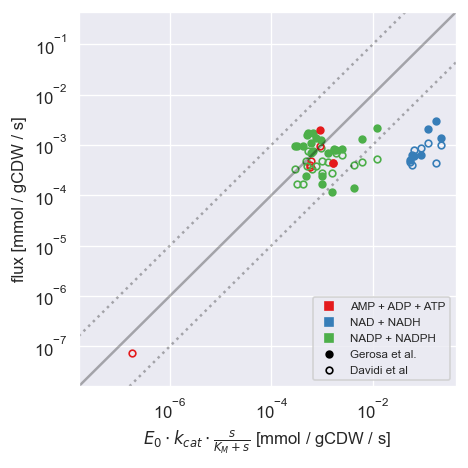

In [5]:
figS1, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120, sharex=True, sharey=True)

_df = joined_df[(joined_df.flux_mmol_per_gCDW_sec > 0) & (~pd.isnull(joined_df.saturation))]
_df.insert(0, "x", _df.kcat_x_adunbance_x_saturation_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec.apply(nominal_value))
vmin = min(_df.x.min(), _df.y.min()) / 2
vmax = max(_df.x.max(), _df.y.max()) * 2

for source, group_df in _df.groupby("flux_source"):
    for row in group_df.itertuples():
        color = reaction2color[row.reaction_BiGG_ID]
        if source == "Gerosa":
            args = {"alpha": 1, "marker": "o", "markerfacecolor": color, "markeredgecolor": color, "markersize": 4, "zorder": 2}
        else:
            args = {"alpha": 1, "marker": "o", "markerfacecolor": "none", "markeredgecolor": color, "markersize": 4, "zorder": 1}
        ax.plot(row.x, row.y, **args)

ax.set_xlabel(r"$E_0 \cdot k_{cat} \cdot \frac{s}{K_M + s}$ [mmol / gCDW / s]")
ax.set_ylabel(r"flux [mmol / gCDW / s]")
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale("log")
ax.set_yscale("log")
legend_elements = [
    Line2D([0], [0], color=cycling_pool2color[c], marker="s", linewidth=0, markersize=5) for c in cycling_pools
] + [
    Line2D([0], [0], markeredgecolor="k", marker="o", markerfacecolor="k", linewidth=0, markersize=4),
    Line2D([0], [0], markeredgecolor="k", marker="o", markerfacecolor="none", linewidth=0, markersize=4),
]
legend_labels = cycling_pools + ["Gerosa et al.", "Davidi et al"]
ax.legend(legend_elements, legend_labels, fontsize=7, loc="lower right")

figS1.tight_layout()

figS1.savefig("res/figS6.pdf")

## Plot supplementary figure S9

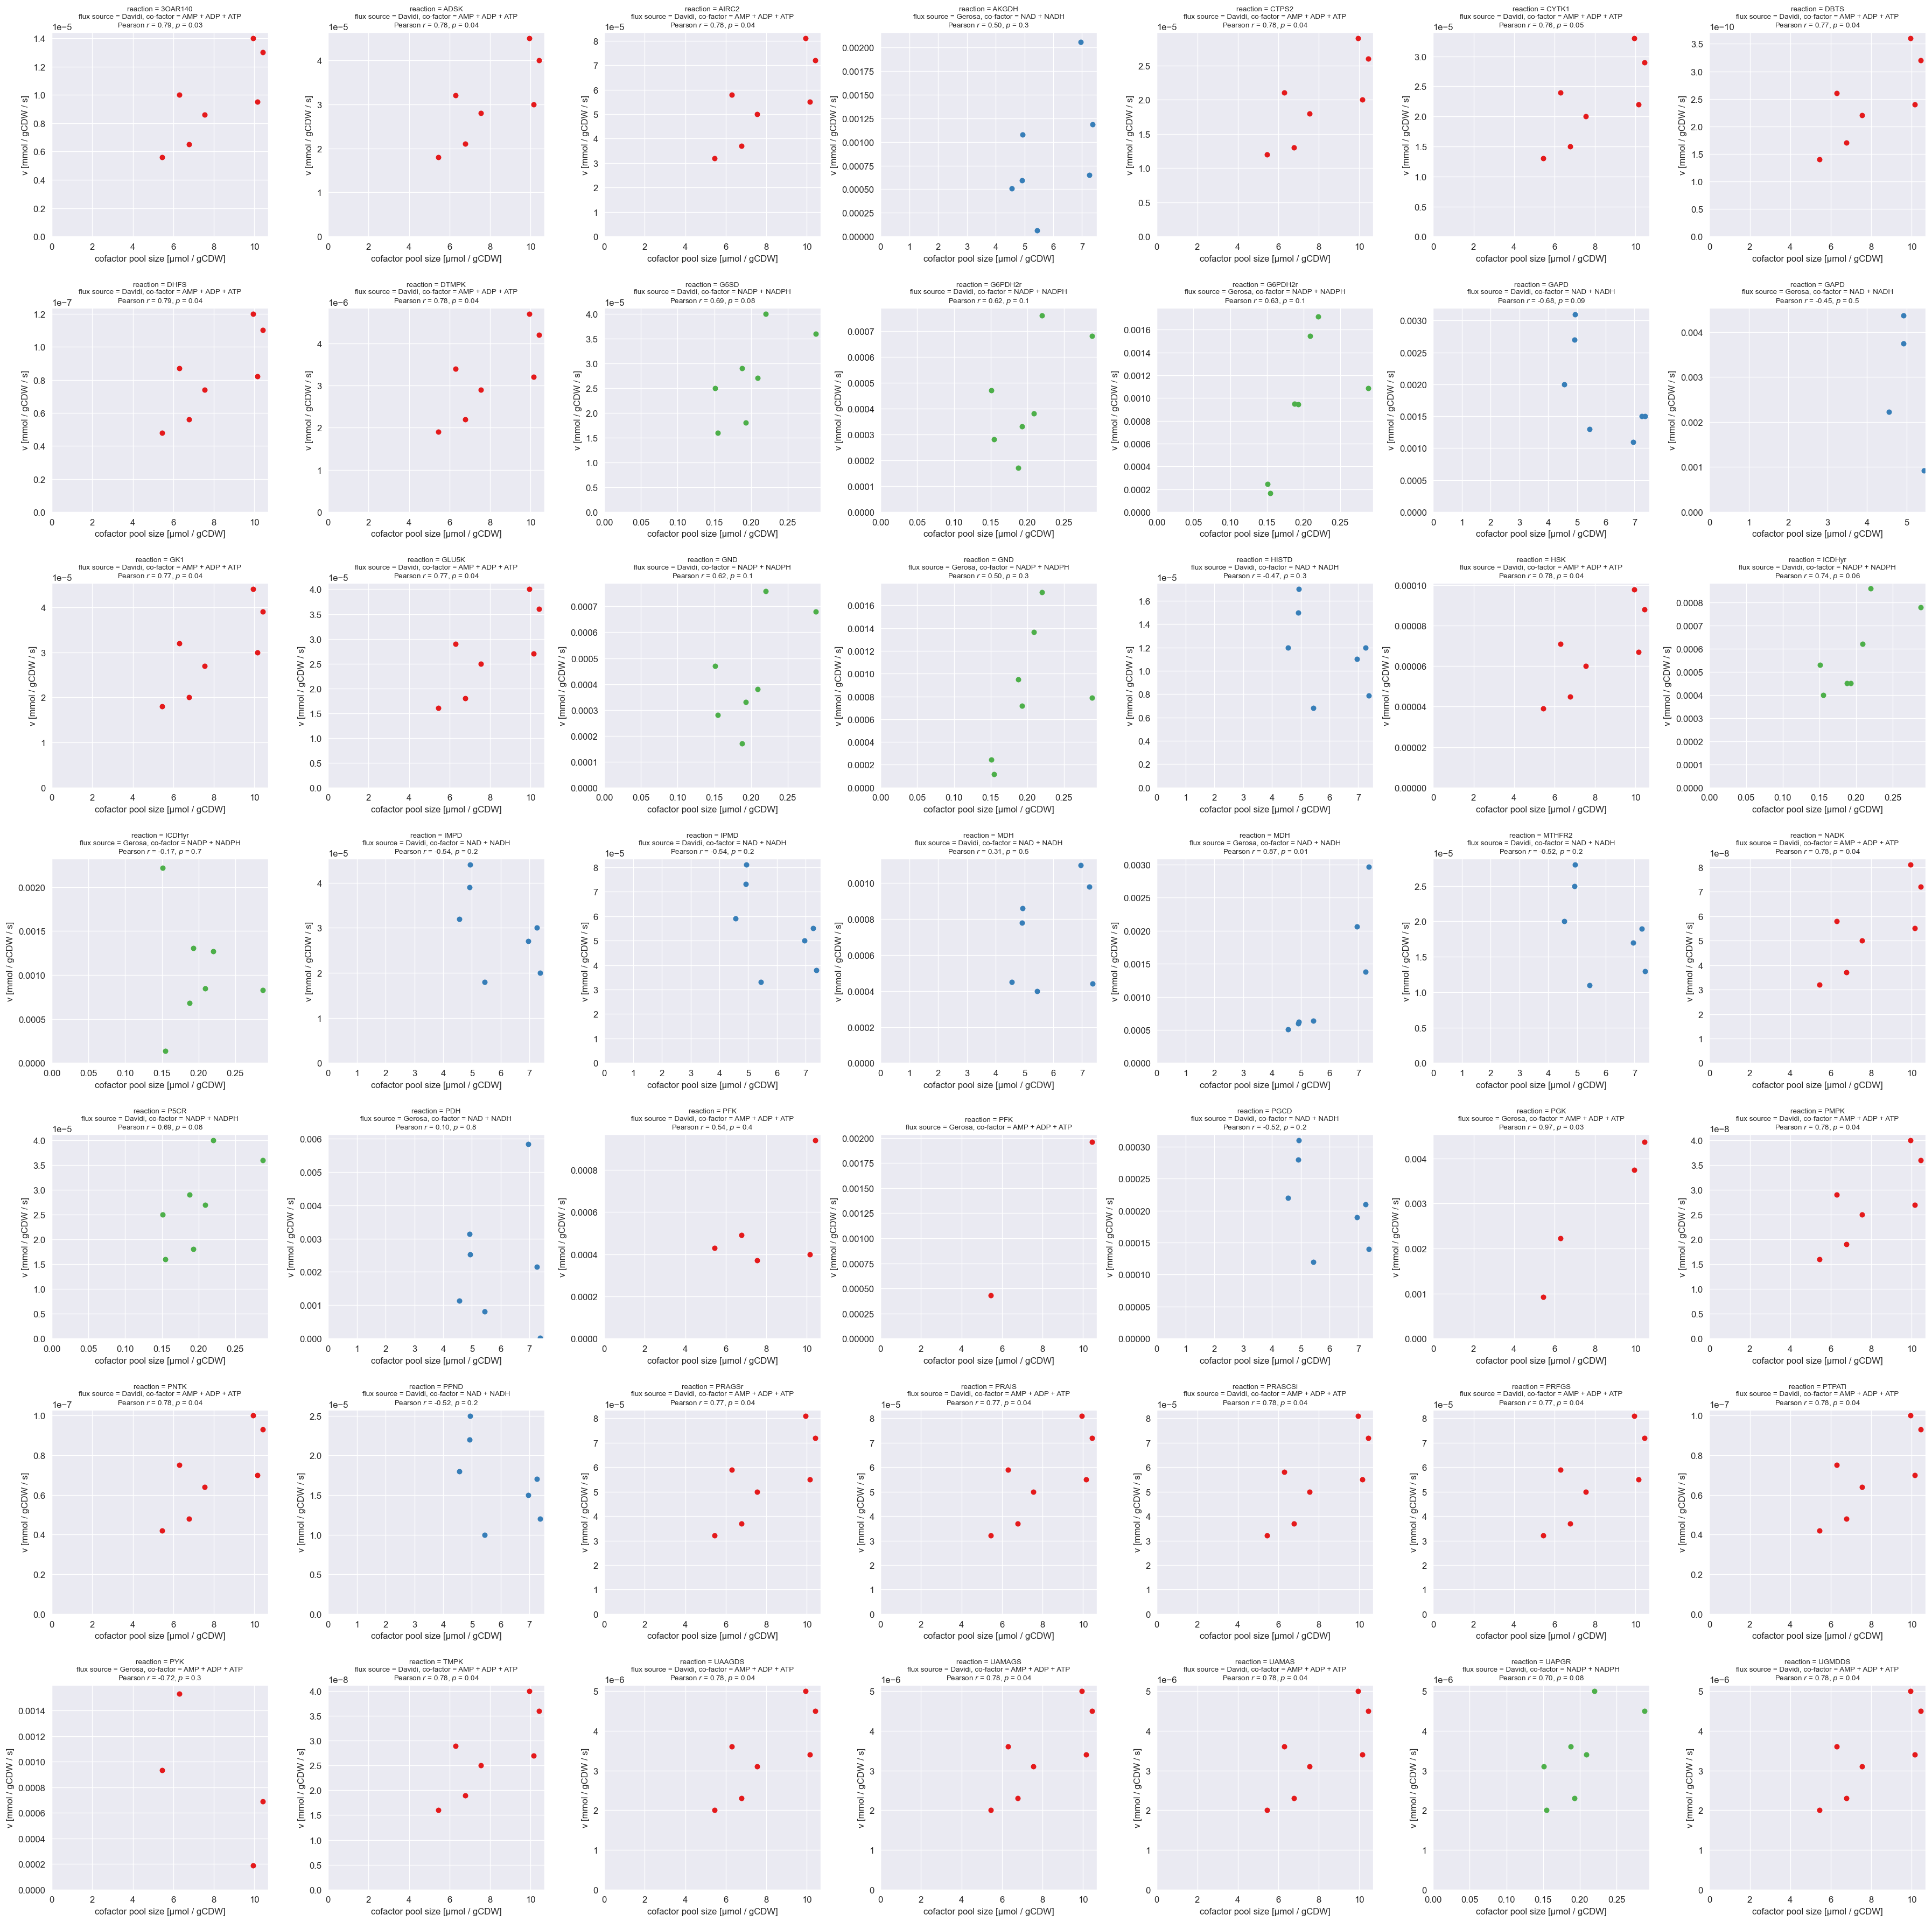

In [6]:
correlation_data = []

figS9, axs = plt.subplots(7, 7, figsize=(30, 30), dpi=120)

for ax, ((reaction, source), group_df) in zip(axs.flat, joined_df[joined_df.flux_mmol_per_gCDW_sec > 0].groupby(["reaction_BiGG_ID", "flux_source"])):

    for row in group_df.itertuples():
        marker = "o"
        color = reaction2color[row.reaction_BiGG_ID]
        ax.plot(
            row.cofactor_concentration_umol_per_gCDW.nominal_value,
            row.flux_mmol_per_gCDW_sec.nominal_value,
            marker=marker,
            markersize=5,
            color=color
        )

    x = group_df.cofactor_concentration_umol_per_gCDW.apply(nominal_value)
    y = group_df.flux_mmol_per_gCDW_sec.apply(nominal_value)

    title = f"reaction = {reaction}\nflux source = {source}, co-factor = {group_df.cycling_pool.iat[0]}"
    if group_df.shape[0] > 3:
        pearson_result = scipy.stats.pearsonr(x, y)
        title += f"\nPearson $r$ = {pearson_result.statistic:.2f}, $p$ = {pearson_result.pvalue:.1g}"
        correlation_data.append((reaction, source, group_df.shape[0], pearson_result.statistic, pearson_result.pvalue))
    else:
        correlation_data.append((reaction, source, group_df.shape[0], np.nan, np.nan))
    ax.set_title(title, fontsize=8)
    ax.set_xlabel("cofactor pool size [μmol / gCDW]")
    ax.set_xlim([0, None])
    ax.set_ylabel("v [mmol / gCDW / s]")
    ax.set_ylim([0, None])
figS9.tight_layout()
figS9.savefig("res/figS9.pdf")

In [7]:
correlation_df = pd.DataFrame(correlation_data, columns=["reaction_BiGG_ID", "flux_source", "number_of_conditions", "pearson_r", "pvalue"])
correlation_df = correlation_df.sort_values("pvalue")
# make a table for the SI with all the correlation data
with open(f"res/correlation.tex", "wt") as fp:
    fp.write(correlation_df.style.to_latex())

display(correlation_df)

,reaction_BiGG_ID,flux_source,number_of_conditions,pearson_r,pvalue
25,MDH,Gerosa,7,0.874310,0.010042
33,PGK,Gerosa,4,0.973547,0.026453
0,3OAR140,Davidi,7,0.794377,0.032850
7,DHFS,Davidi,7,0.787719,0.035438
46,UAMAS,Davidi,7,0.783767,0.037025
45,UAMAGS,Davidi,7,0.783767,0.037025
44,UAAGDS,Davidi,7,0.783767,0.037025
48,UGMDDS,Davidi,7,0.783767,0.037025
2,AIRC2,Davidi,7,0.783523,0.037125
39,PRASCSi,Davidi,7,0.783523,0.037125


## Plot supplementary figure S7

/home/eladn/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in absolute
  result = func(self.values, **kwargs)
/home/eladn/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in absolute
  result = func(self.values, **kwargs)


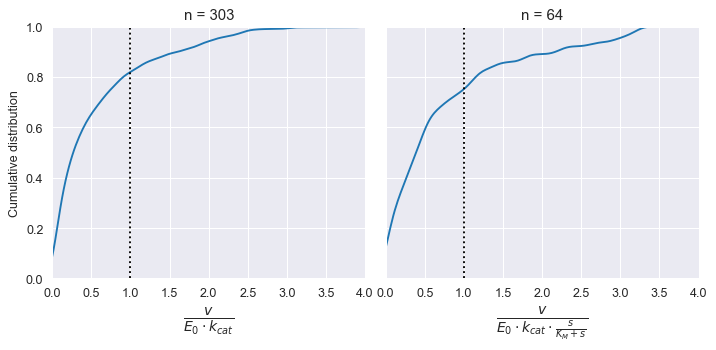

In [8]:
figS7, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=90, sharex=True, sharey=True)

ax = axs[0]
_df = joined_df.flux_mmol_per_gCDW_sec.abs()/joined_df.kcat_x_adunbance_mmol_per_gCDW_sec
_df = _df[_df > 0].apply(nominal_value)
sns.kdeplot(_df, cumulative=True, bw_method=0.1, ax=ax)
ax.plot([1, 1], [0, 1], "k:")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
ax.set_ylabel("Cumulative distribution")
ax.set_xlabel(r"$\frac{v}{E_0 \cdot k_{cat}}$", fontsize=16)
ax.set_title(f"n = {_df.shape[0]}")

ax = axs[1]
_df = joined_df.flux_mmol_per_gCDW_sec.abs()/ joined_df.kcat_x_adunbance_x_saturation_mmol_per_gCDW_sec
_df = _df[_df > 0].apply(nominal_value)
sns.kdeplot(_df, cumulative=True, bw_method=0.1, ax=ax)
ax.plot([1, 1], [0, 1], "k:")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
ax.set_ylabel("Cumulative distribution")
ax.set_xlabel(r"$\frac{v}{E_0 \cdot k_{cat} \cdot \frac{s}{K_M + s}}$", fontsize=16)
ax.set_title(f"n = {_df.shape[0]}")
figS7.tight_layout()
figS7.savefig("res/figS7.pdf")

## Plot main figure 3

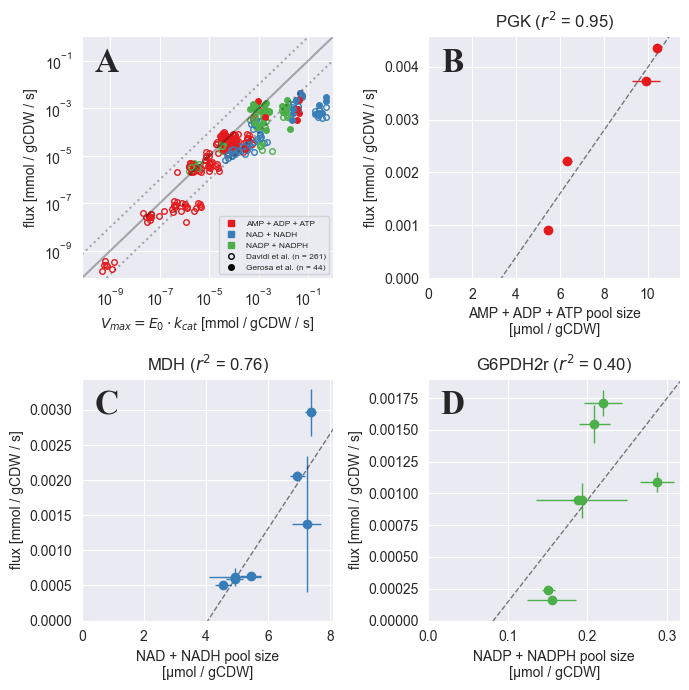

In [9]:
fig3, axs = plt.subplots(2, 2, figsize=(7, 7), dpi=100)

ax = axs[0, 0]

_df = joined_df[(joined_df.flux_mmol_per_gCDW_sec != 0) & (~pd.isnull(joined_df.kcat_x_adunbance_mmol_per_gCDW_sec))].copy()
_df.insert(0, "x", _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec.apply(nominal_value).abs())
_df.insert(2, "yerr", _df.flux_mmol_per_gCDW_sec.apply(std_dev))
vmin = min(_df.x.min(), _df.y.min()) / 2
vmax = max(_df.x.max(), _df.y.max()) * 2

legend_labels = cycling_pools.copy()
legend_elements = [
    Line2D([0], [0], color=cycling_pool2color[c], marker="s", linewidth=0, markersize=5) for c in cycling_pools
]

for source, group_df in _df.groupby("flux_source"):
    if source == "Gerosa":
        markerfacecolor = "k"
    else:
        markerfacecolor = "none"

    legend_labels += [f"{source} et al. (n = {group_df.shape[0]})"]
    legend_elements += [Line2D([0], [0], markeredgecolor="k", marker="o", markerfacecolor=markerfacecolor, linewidth=0, markersize=4)]
    for row in group_df.itertuples():
        color = reaction2color[row.reaction_BiGG_ID]
        args = {
            "alpha": 1, "marker": "o", "linewidth": 0,
            "markeredgecolor": color,
            "markersize": 4, "zorder": 2,
            #"elinewidth": 1,
        }
        if source == "Gerosa":
            args["markerfacecolor"] = color
        else:
            args["markerfacecolor"] = "none"
        #ax.errorbar(row.x, row.y, row.yerr, **args)
        ax.plot(row.x, row.y, **args)

ax.set_xlabel(r"$V_{max} = E_0 \cdot k_{cat}$ [mmol / gCDW / s]")
ax.set_ylabel("flux [mmol / gCDW / s]")
ax.legend(legend_elements, legend_labels, fontsize=6, loc="lower right")
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale("log")
ax.set_yscale("log")

_df = joined_df[
    (joined_df.flux_mmol_per_gCDW_sec > 0) &
    (joined_df.flux_source == "Gerosa")
]
bigg_ids = correlation_df[(correlation_df.flux_source == "Gerosa") & (correlation_df.pearson_r > 0.6)].reaction_BiGG_ID
_df = _df[_df.reaction_BiGG_ID.isin(bigg_ids)]
_df = _df.sort_values("cycling_pool")

for ax, ((cycling_pool, reaction), group_df) in zip(axs.flat[1:], _df.groupby(["cycling_pool","reaction_BiGG_ID"])):

    x = group_df.cofactor_concentration_umol_per_gCDW.apply(nominal_value)
    xerr = group_df.cofactor_concentration_umol_per_gCDW.apply(std_dev)
    y = group_df.flux_mmol_per_gCDW_sec.apply(nominal_value)
    yerr = group_df.flux_mmol_per_gCDW_sec.apply(std_dev)

    ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linewidth=0, elinewidth=1, color=reaction2color[reaction])

    #a = (x@y)/(x@x)  # slope of best fitting line without offset

    pearson_result = scipy.stats.pearsonr(x, y)

    A = np.vstack([x, np.ones(len(x))]).T
    lstsq_result, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
    a, b = lstsq_result

    title = f"{reaction} ($r^2$ = {pearson_result.statistic**2:.2f})"
    maxx = max(x)*1.1
    ax.set_ylim([0, None])
    ax.set_xlim([0, maxx])
    ax.set_title(title)
    ax.plot([0, maxx], [b, a*maxx+b], "k--", linewidth=1, alpha=0.5)

    ax.set_ylabel("flux [mmol / gCDW / s]")
    ax.set_xlabel(f"{cycling_pool} pool size\n[μmol / gCDW]")

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(24)
font.set_weight("bold")
for i, ax in enumerate(axs.flat):
    label = chr(ord("A")+i)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontproperties=font, va='top')
fig3.tight_layout()
fig3.savefig("res/fig3.pdf")

## Plot supplementary figure S8

Here we test the hypothesis that Haldane kinetics are a determinant of the $v/V_{max}$ (i.e. explain cases where enzyme $k_app$ is lower than $k_cat$. We have to assume, however, that all $K_M$ values are the same, and that all reactants are at 1 mM.

/home/eladn/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in absolute
  result = func(self.values, **kwargs)


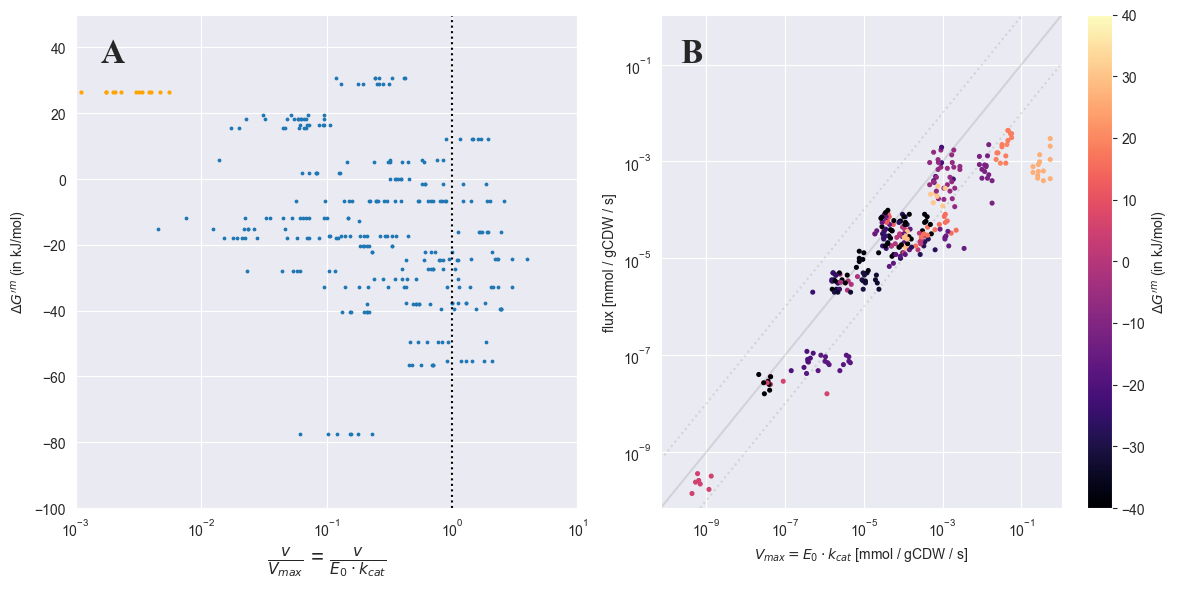

In [10]:
figS8, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

ax = axs[1]

v_over_vmax = joined_df.flux_mmol_per_gCDW_sec.abs()/joined_df.kcat_x_adunbance_mmol_per_gCDW_sec
_df = joined_df.copy()
_df = _df[(_df.flux_mmol_per_gCDW_sec > 0) & (~pd.isnull(_df.kcat_x_adunbance_mmol_per_gCDW_sec))]
_df.insert(0, "v_over_vmax", v_over_vmax.apply(nominal_value))
_df.insert(1, "x", _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(2, "y", _df.flux_mmol_per_gCDW_sec.apply(nominal_value).abs())
_df.insert(3, "yerr", _df.flux_mmol_per_gCDW_sec.apply(std_dev))
vmin = min(_df.x.min(), _df.y.min()) / 2
vmax = max(_df.x.max(), _df.y.max()) * 2

sc = ax.scatter(_df.x, _df.y, c=_df.dGm, s=7, cmap="magma", vmin=-40, vmax=40, zorder=2)
plt.colorbar(sc, label=r"$\Delta G'^m$ (in kJ/mol)")
#ax.set_facecolor("#F3F3F3")
ax.set_xlabel(r"$V_{max} = E_0 \cdot k_{cat}$ [mmol / gCDW / s]")
ax.set_ylabel("flux [mmol / gCDW / s]")
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.1, label="upper bound", zorder=1)
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.1, label="x10 upper bound", zorder=1)
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.1, label="x0.1 upper bound", zorder=1)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale("log")
ax.set_yscale("log")

ax = axs[0]
_df_mdh = _df[_df.reaction_BiGG_ID == "MDH"]
ax.scatter(x=_df_mdh.v_over_vmax, y=_df_mdh.dGm, s=4, color="orange", label=f"MDH (n = {_df_mdh.shape[0]})")
_df_nonmdh = _df[_df.reaction_BiGG_ID != "MDH"]
ax.scatter(x=_df_nonmdh.v_over_vmax, y=_df_nonmdh.dGm, s=3, label=f"all others (n = {_df_nonmdh.shape[0]})")
ax.set_xlabel(r"$\frac{v}{V_{max}}$ = $\frac{v}{E_0 \cdot k_{cat}}$", fontsize=16)
ax.set_ylabel(r"$\Delta G'^m$ (in kJ/mol)")
ax.set_xscale("log")
ax.set_xlim(1e-3, 10)
ax.set_ylim(-100, 50)
ax.plot([1, 1], [-100, 50], "k:")

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(24)
font.set_weight("bold")
for i, ax in enumerate(axs.flat):
    label = chr(ord("A")+i)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontproperties=font, va='top')

figS8.tight_layout()
figS8.savefig("res/figS8.pdf")